Load Python Libraries

In [25]:
Version: 1.6

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
import matplotlib.dates as mdates
%matplotlib inline

Import PV Data. PV Data's format has 5 columns, with 2nd column representing the kW output of each hourly period, 1st column: DateTime

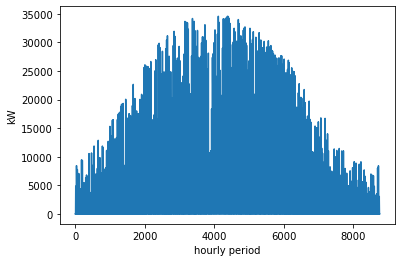

Annual Solar Generation: 48494533.25 kWh
8760


In [26]:
# import data
solar_profile = pd.read_csv("C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/Data/OxfordSolar50MWhourly.csv", usecols=[1]).values

# plot data
plt.plot(solar_profile)  # just plotting a single day from the entire year
plt.ylabel("kW")
plt.xlabel("hourly period")
plt.show()

# calculate annual generation
print("Annual Solar Generation: {:.2f} kWh".format(solar_profile.sum()))
 
print(len(solar_profile))

Create Electrolyzer Class and Location Class


In [27]:
class electrolyzer:
    def __init__(self,production_rate,max_power):
        self.production_rate = production_rate     #kg of hydrogen produced per second per MW of electricity
        self.max_power = max_power                 #in MW
        
class alkaline(electrolyzer):
    def __init__(self,production_rate, max_power):
        super().__init__(production_rate, max_power)
        self.min_power = max_power*15/100  # in MW, minimum power to retain its ability to ramp up and down quickly  
        self.lifetime = 65000
        self.install_cost = max_power * 908 *1000
        
class ITM_PEM(electrolyzer):
    def __init__(self,production_rate, max_power):
        super().__init__(production_rate, max_power)
        self.min_power = max_power*10/100  # in MW, minimum power to retain its ability to ramp up and down quickly  
        self.lifetime = 50000
        self.install_cost = max_power * 574 *1000
    
class location:
    def __init__(self, var_waterprice, fixed_waterprice,elec_price):
        self.var_waterprice = var_waterprice               # price per m3
        self.fixed_waterprice = fixed_waterprice           # price per day 
        self.elec_price = elec_price                       #GBP Per MWh
        
class battery:
    def __init__(self, power_rating, capacity):
        self.power_rating = power_rating             # power rating of battery in MW
        self.capacity = capacity                     # energy capacity of battery in MJ
        
class energysystem: 
    def __init__(self,location,electrolyzer):
        self.location = location
        self.electrolyzer = electrolyzer
        

    
  #  def CapEx(self): 
   #     CapEx = self.location.fixed_waterprice + self.electrolyzer.install_cost
    #    return CapEx 
        
    #def OpEx:   #water and electricity costs per kg of hydrogen 
        
    #    return OpEx

ITM HGas3SP Electrolyzer created below

In [28]:
itm_H3GSP = ITM_PEM(0.01/2.35,2.35)
NEL_A3880 = alkaline(0.0958/17.072, 17.072)
Oxford = location(1.4570,(17.84/30),160.3)
itm_35MW = ITM_PEM(0.0243, 35)

test_batt = battery(1, 7200)
test1 = energysystem(Oxford,itm_H3GSP)
test2 = energysystem(Oxford,NEL_A3880)

test1.location.fixed_waterprice

0.5946666666666667

In [29]:
Power = solar_profile*0.001                   #Average power(MW) of solar grid in the hourly period


Theoretical Electrolyzer Power Output in each hour period <br>
(Taking into account max rate of change of power) <br>
(Without taking into account max and min power)

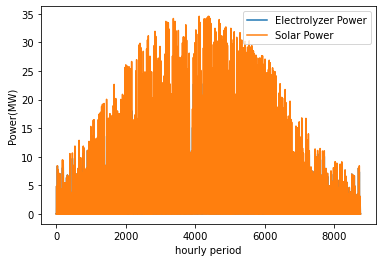

In [30]:
T = len(Power)                           # no. of hourly periods
grid_demand = np.zeros((T,1))            # power required from grid 
H_produced = np.zeros((T,1))             # kg of hydrogen produced in the hour period


# solar power change compared to  previous hour period
p_change = np.zeros((T,1))               
for j in range(T):
    if j == 0: 
        p_change[j] = 0
    else: 
        p_change[j] = Power[j] - Power[j-1]

# for this test, we will set max power change of electrolyzer to be 2e-4 MW per hour
max_p_change = 2

needed_p_change = np.zeros((T,1))            # power change needed for electrolyzer
electrolyzer_power = np.zeros((T,1))

for j in range(T):
    if j == 0:
        electrolyzer_power[j] = Power[j]
        needed_p_change[j] = 0
    else: 
        needed_p_change[j] = Power[j] - electrolyzer_power[j-1]
    
    if abs(needed_p_change[j]) > max_p_change:      #if electrolyzer cannot handle power change
        electrolyzer_power[j] = electrolyzer_power[j-1] + np.sign(needed_p_change[j])*max_p_change
        
    elif abs(needed_p_change[j]) <= max_p_change:   #if electrolyzer can handle power change
        if electrolyzer_power[j-1] == Power[j-1]:      # if electrolyzer is handling it well
            electrolyzer_power[j] = Power[j]
        elif electrolyzer_power[j-1] != Power[j-1]:     # if electrolyzer was not in sync with solar power 
            electrolyzer_power[j] = electrolyzer_power[j-1] + np.sign(needed_p_change[j])*min(abs(max_p_change),abs(needed_p_change[j]))
            
ax = plt.subplot(1,1,1)
plt.plot(electrolyzer_power, label = 'Electrolyzer Power')
plt.plot(Power, label = 'Solar Power')
plt.xlabel('hourly period')
plt.ylabel('Power(MW)')

ax.legend()


State of electrolyser (1 for one and 0 for off)

In [31]:
state = np.ones((T,1)) 
for i in range(104):
    state[0+i*24:6+i*24] =0
    state[17+i*24:23+i*24] =0

for i in range(105,239):
    state[0+i*24:4+i*24] =0
    state[20+i*24:23+i*24] =0

    
for i in range(240,364):
    state[0+i*24:6+i*24] =0
    state[17+i*24:23+i*24] =0
    

Battery

In [32]:
batt_power = np.zeros((T,1))             #Amt of power loaded into battery in MW
batt_soc = np.zeros((T,1))               #Amt of energy stored in battery in MWh


Hydrogen produced in each hourly period <br>
(Taking into account max and min power) <br>
Cost of electricity if electrolyzer takes electricity from grid <br>
Cost of water  <br>
CO2 emissions from grid electricity<br>
Assuming electrolyser is powered by solar power by default: CO2 emissions of solar power

Max Battery Power Rating needed(in MW) is
[1.]


Text(0, 0.5, 'Battery State of Charge (in GJ)')

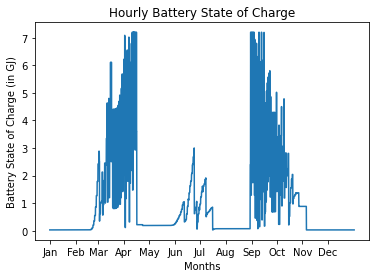

In [42]:
# electrolyzer takes electricity from grid, if solar power falls below min power 
# assume solar power is free 

batt = test_batt                          # test battery has power of 1MW and capacity of 2MWh
electrolyser = itm_35MW

# Records hydrogen produced in each hour period
for j in range(T):
    #if electrolyser is on
    if state[j] == 1:
        if electrolyzer_power[j] > electrolyser.max_power:                              #if theoretical power exceeds max power
            H_produced[j] = electrolyser.max_power*electrolyser.production_rate*60*60 
            batt_power[j] = min((electrolyzer_power[j] - electrolyser.max_power), batt.power_rating)
            batt_soc[j] = min((batt_soc[j-1] + batt_power[j]*60*60), batt.capacity)
        elif electrolyzer_power[j] >= electrolyser.min_power:                           #if theoretical power is within acceptable range      
            H_produced[j] = electrolyzer_power[j]*electrolyser.production_rate*60*60
            batt_soc[j] = batt_soc[j-1]
        else:                                                                           #if theoretical power is below min power
            H_produced[j] = electrolyser.min_power*electrolyser.production_rate*60*60
            grid_demand[j] = electrolyser.min_power - electrolyzer_power[j] 
            
            if grid_demand[j] > batt.power_rating:                                 #if power demand exceeds battery power rating
                if batt_soc[j-1] > batt.power_rating*60*60:
                    batt_soc[j] = batt_soc[j-1] - batt.power_rating*3600
                    grid_demand[j] = grid_demand[j] - batt.power_rating
                else:
                    batt_soc[j] = batt_soc[j-1]
            elif grid_demand[j] < batt.power_rating:                               #if power demand is within battery power rating
                #if there is sufficient energy in battery storage
                if batt_soc[j-1] > grid_demand[j]*60*60:
                    batt_soc[j] = batt_soc[j-1] - grid_demand[j]*3600
                else:
                    batt_soc[j] = batt_soc[j-1]
                
    #if electrolyser is off
    else:
        H_produced[j] = 0
        batt_power[j] = min(Power[j],batt.power_rating)
        batt_soc[j] = min((batt_soc[j-1] + batt_power[j]*60*60),batt.capacity)
        
print('Max Battery Power Rating needed(in MW) is')
print(max(batt_power))

ax = plt.subplot(1,1,1)
plt.plot(batt_soc/1000)
plt.title("Hourly Battery State of Charge")
plt.xticks([0,744,1392,2136,2856,3600,4320,5064,5808,6528,7272,7992])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')
plt.ylabel('Battery State of Charge (in GJ)')


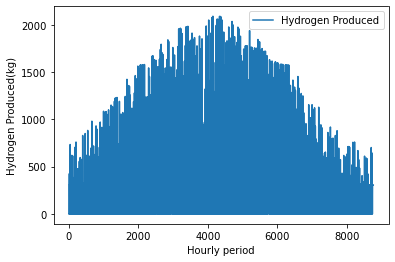

In [34]:
ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Hydrogen Produced')
plt.xlabel('Hourly period')
plt.ylabel('Hydrogen Produced(kg)')

ax.legend()


CO2 emissions and operating costs

In [35]:
#Solar Power needed in each hour
co2persolar = 0    #gCO2e per kWh

solar_power = np.zeros((T,1))
for j in range(T):
    if state[j] == 1 :  
        solar_power[j] = electrolyzer_power[j]
    if state[j] == 0 :
        solar_power[j] = batt_power[j]
solar_co2_emissions = sum(solar_power*co2persolar*1000)       #in grams

co2perelec = 256                                               #gCO2e per kWh
grid_co2_emissions = sum(grid_demand*co2perelec*1000)          #in grams


print('Total co2 emissions from electricity is')
print(solar_co2_emissions+grid_co2_emissions)


Total_elec_cost =sum(grid_demand* Oxford.elec_price)
print('Total cost of grid electricity consumption is')
print(Total_elec_cost)

Water_consumption = 9                                         #kg of water needed for each kg of hydrogen

Total_water_price = T*Oxford.fixed_waterprice + sum(H_produced*Water_consumption*Oxford.var_waterprice)

print('Total cost of water consumption is')
print(Total_water_price)

Total co2 emissions from electricity is
[1.01200273e+09]
Total cost of grid electricity consumption is
[633687.64437069]
Total cost of water consumption is
[49000060.24114704]


Daily Hydrogen Production throughout the year 

Total hydrogen produced (in kg) is
[3736357.12355282]


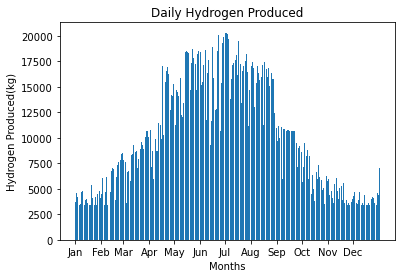

In [36]:
No_of_days = T/24
No_of_days = int(No_of_days)
daily_H2_pd = np.zeros((No_of_days))
for i in range(int(No_of_days)):
    daily_H2_pd[i] = sum(H_produced[(0 + i*24):(23 + i*24)])

ax = plt.subplot(1,1,1)

#plt.plot(daily_H2_pd, label = 'Daily Hydrogen Produced')
daysNum = len(daily_H2_pd)
daySet = np.arange(1,daysNum+1)
plt.bar(daySet,daily_H2_pd)
plt.title("Daily Hydrogen Produced")
plt.xticks([0,31,58,89,119,150,180,211,242,272,303,333])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')
plt.ylabel('Hydrogen Produced(kg)')

total_annual_hydrogen = sum(H_produced)
print('Total hydrogen produced (in kg) is')
print(total_annual_hydrogen)

Reverse Engineer actual electrolyzer power 

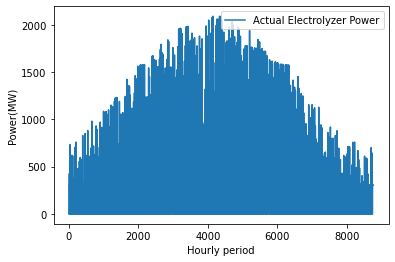

In [37]:
actual_electrolyzer_power = H_produced / electrolyser.production_rate

ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Actual Electrolyzer Power')
plt.xlabel('Hourly period')
plt.ylabel('Power(MW)')

ax.legend()

Code for Hydrogen Storage

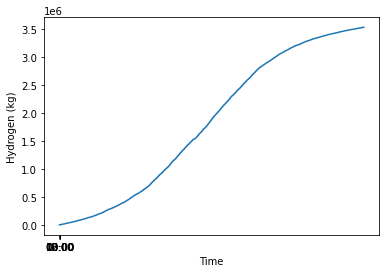

In [38]:
hydrogen_capacity = 10  # kg

T = len(solar_profile)                    # no. of half hour periods
outputi = np.zeros((T,1))  # hydrogen production flow
soc = np.zeros((T,1))  # weight of hydrogen stored


for j in range(T):
    if j == 0:
        socval = 0 
    else:
        socval = soc[j-1]                 #stores soc from the previous timeslot
    
    # if there is production of hydrogen
    if Power[j] > 0:      
        outputi[j] = H_produced[j]
        soc[j] = socval + outputi[j]     #battery is being discharged so soc decreases
        
    # if there is no production of hydrogen
    elif solar_profile[j] == 0: 
        soc[j] = socval                     # battery soc has no change

        
ax = plt.subplot(1,1,1)
p = plt.plot(soc)

plt.xticks([0,6,12,18,24])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
plt.ylabel('Hydrogen (kg)', color='k')
plt.xlabel('Time', color='k')
plt.show()

Converts array into csv

In [39]:
#pd.DataFrame(daily_H2_pd).to_csv(r'C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/data.csv',index = False)

Net Present Cost of electrolyser <br>
Assuming a yearly depreciation to a value of zero at the end of the lifetime<br>
Lifetime of electrolyser is depleted for each non-zero output 

In [43]:
lifetime = electrolyser.lifetime
print(lifetime)
discount_rate = 0.0025
operating_hours = np.count_nonzero(H_produced)
years_lifetime = np.round(lifetime/operating_hours)
years_lifetime = int(years_lifetime)
print(years_lifetime)
annual_cost = electrolyser.install_cost/years_lifetime

cost = np.zeros((years_lifetime,1))   
for j in range(years_lifetime):
    cost[j] = annual_cost *((1-discount_rate)**j)
    
npv = sum(cost)

50000
10


In [41]:
print(npv)

[15270973.53745241]
